<a href="https://colab.research.google.com/github/sghuffar/GlacierDelineation/blob/master/GlacierDelineationDeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a code to segment a Landsat ETM+ image in to glacier and non glacier binary image. The segmentation is performed using the U-Net convolutional Neural Network model trained using the Pytorch Library. 
Part of the code is based on the following implementation: Deep networks for Earth Observation (https://github.com/nshaud/DeepNetsForEO). I would like to hereby acknowledge that the above mentioned respository has helped me in getting starting with Deep Learning for remote sensing image segmentation using Pytorch. I am grateful to the authors for sharing their code. 

In order to run this code, a Google account is required. The Landsat ETM+ image is exported from the EarthEngine to the Drive and then feeded in to the neural network for prediction. The exporting of the image to the Google Drive may take 5-10 minutes.

The False color original image as well as the predicted mask is then displayed on the map. 

The user needs to auhtorize access to the Google Drive below


In [0]:
!pip install pyproj   # pyproj is required for coordinate transformations
import torch
print(torch.__version__)
import torch.nn.functional as F
from skimage import io
from glob import glob
import folium   # for visualizing maps and images
import random
import itertools
import gdal
import matplotlib.pyplot as plt
import os.path
from torch.autograd import Variable
import numpy as np
import os
import torch.nn as nn
from torchvision import transforms  
import torch.utils.data as data
import torch.optim as optim
import torch.optim.lr_scheduler
import torch.nn.init
from tqdm import tqdm
import numpy as np
from pyproj import Proj, transform
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    
use_cuda = True

from google.colab import drive
drive.mount('/content/gdrive')

As we are using Earth Engine libraries to read and export the Landsat image, one would need to authorize access for Earth Engine. Copy paste the code below for authorization. 

In [0]:
!pip install earthengine-api  # install the Earth Engine API
!earthengine authenticate
import ee
ee.Initialize()


Below we select a Landsat ETM+ image. At the moment only a central region of the image is exported because exporting a full image takes quite long time

In [0]:
image=ee.Image('LANDSAT/LE07/C01/T1/LE07_149035_20010930')  #change the name of this image if testing on another image is required
projI=image.select('B1').projection().getInfo()    # Exporting the whole image takes time, therefore, roughly select the center region of the image
crs=projI['crs']
outProj=Proj(init='epsg:4326')
inProj=Proj(init=crs)
kk=projI['transform']
print(projI)
lon1, lat1=transform(inProj,outProj,kk[2]+(2000*30),kk[5]-(2000*30))
lon2, lat2=transform(inProj,outProj,kk[2]+(5000*30),kk[5]-(5000*30)) #change these coordinates to increase or decrease image size

bounds = [lon1, lat2, lon2, lat1]
print(bounds,lon1,lat1)

imageL7=imageL7.select(['B1','B2','B3','B4','B5','B6_VCID_2','B7','B8'])
geometry = ([lon1, lat1],[lon1,lat2],[lon2,lat2],[lon2 ,lat1])
config= {
    'description':'Landsat07image',    
    'region':geometry ,
    'scale': 15,  #the image is exported with 15m resolution
    'fileFormat': 'GeoTIFF',
    'maxPixels':'1e12'
}

exp=ee.batch.Export.image.toDrive(imageL7,**config);

exp.start()   # It takes around 5-10 minutes for 6000 * 6000 * 8 image to be exported 
print(exp.status())
print(ee.batch.Task.list())
import time
while exp.active():
  print('Transferring Data to Drive..................')
  time.sleep(30)
print('Done with the Export to the Drive')

This portion contains the network definition. At the moment I am taking GroupNorm equal to number of channels which should be equal to the instance Norm. There are four encoder and four decoder units. 

In [0]:
class ConvBnRelu(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding, stride):
        super(ConvBnRelu, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding, stride=stride)
        #self.bn = nn.BatchNorm2d(in_channels)
        self.bn = nn.GroupNorm(in_channels,in_channels)
       # self.relu = nn.ReLU()
        self.relu = nn.LeakyReLU()

    def forward(self, x): 
        x = self.bn(x)
        x = self.conv(x)       
        x = self.relu(x)        
        return x



class StackEncoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(StackEncoder, self).__init__()
        self.convr1 = ConvBnRelu(in_channels, out_channels, kernel_size=(3, 3), stride=1, padding=1)
        self.convr2 = ConvBnRelu(out_channels, out_channels, kernel_size=(3, 3), stride=1, padding=1)
        self.maxPool = nn.MaxPool2d(kernel_size=(2, 2), stride=2)

    def forward(self, x):
        x = self.convr1(x)
        x = self.convr2(x)
        
        x_trace = x
        x = self.maxPool(x)
        return x, x_trace


class StackDecoder(nn.Module):
    def __init__(self, in_channels1,in_channels2, out_channels):
        super(StackDecoder, self).__init__()

        #self.upSample = nn.Upsample(scale_factor=2, mode="bilinear")
        self.upSample = nn.ConvTranspose2d(in_channels1,in_channels1, (2,2), stride=2)
        
        self.convr1 = ConvBnRelu(in_channels1+in_channels2, out_channels, kernel_size=(3, 3), stride=1, padding=1)
        self.convr2 = ConvBnRelu(out_channels, out_channels, kernel_size=(3, 3), stride=1, padding=1)
    def _crop_concat(self, upsampled, bypass):
        return torch.cat((upsampled, bypass), 1)

    def forward(self, x, down_tensor):
        x = self.upSample(x)
        x = self._crop_concat(x, down_tensor)
        x = self.convr1(x)    
        x = self.convr2(x)
       # x = self.convr3(x)
        return x


class UNetOriginal(nn.Module):
    @staticmethod
    def weight_init(m):
        if isinstance(m, nn.Conv2d):
            torch.nn.init.xavier_uniform(m.weight.data)

    def __init__(self, in_shape):
        super(UNetOriginal, self).__init__()
        channels, height, width = in_shape

        self.down1 = StackEncoder(channels,16)
        self.down2 = StackEncoder(16, 16)
        self.down3 = StackEncoder(16, 32)
        self.down4 = StackEncoder(32,32)

        self.center = nn.Sequential(
            ConvBnRelu(32, 32, kernel_size=(3, 3), stride=1, padding=1),
            ConvBnRelu(32, 32, kernel_size=(3, 3), stride=1, padding=1)
        )

        self.up1 = StackDecoder(in_channels1=32,in_channels2=32, out_channels=32)
        self.up2 = StackDecoder(in_channels1=32,in_channels2=32, out_channels=32)
        self.up3 = StackDecoder(in_channels1=32,in_channels2=16, out_channels=16)
        self.up4 = StackDecoder(in_channels1=16,in_channels2=16, out_channels=16)

        self.output_seg_map = nn.Conv2d(16, 2, kernel_size=(1, 1), padding=0, stride=1)

    def forward(self, x):
        x, x_trace1 = self.down1(x)  
        x, x_trace2 = self.down2(x)
        x, x_trace3 = self.down3(x)
        x, x_trace4 = self.down4(x)

        x = self.center(x)

        x = self.up1(x, x_trace4)
        x = self.up2(x, x_trace3)
        x = self.up3(x, x_trace2)
        x = self.up4(x, x_trace1)

        out = self.output_seg_map(x)
        out = torch.squeeze(out, dim=1)
        return out

The inference using the trained model is done here.  The "UNet_Glaciers" contains the trained model. The input image is imported from the Google Drive. 


['/content/gdrive/My Drive/Landsat07image.tif']


  0%|          | 0/144 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:87: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


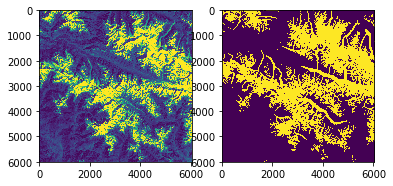

In [7]:

WINDOW_SIZE = (1024 ,1024) # Patch size
IN_CHANNELS =8  # Use 8 bands of ETM+
BATCH_SIZE =4  # Number of samples in a mini-batch

LABELS = ["Backgr","Glaciers"] # Label names
N_CLASSES = len(LABELS) # Number of classes
WEIGHTS = torch.ones(N_CLASSES) # Weights for class balancing
CACHE = False # Store the dataset in-memory



def CrossEntropy2d(input, target, weight=None, size_average=True):
    """ 2D version of the cross entropy loss """
    dim = input.dim()
    if dim == 2:
        return F.cross_entropy(input, target, weight, size_average)
    elif dim == 4:
        output = input.view(input.size(0),input.size(1), -1)
        output = torch.transpose(output,1,2).contiguous()
        output = output.view(-1,output.size(2))
        target = target.view(-1)
        return F.cross_entropy(output, target,weight, size_average)
    else:
        raise ValueError('Expected 2 or 4 dimensions (got {})'.format(dim))

def accuracy(input, target):
    return 100 * float(np.count_nonzero(input == target)) / target.size

def sliding_window(top, step=10, window_size=(20,20)):
    """ Slide a window_shape window across the image with a stride of step """
    for x in range(0, top.shape[0], step):
        if x + window_size[0] > top.shape[0]:
            x = top.shape[0] - window_size[0]
        for y in range(0, top.shape[1], step):
            if y + window_size[1] > top.shape[1]:
                y = top.shape[1] - window_size[1]
            yield x, y, window_size[0], window_size[1]
            
def count_sliding_window(top, step=10, window_size=(20,20)):
    """ Count the number of windows in an image """
    c = 0
    for x in range(0, top.shape[0], step):
        if x + window_size[0] > top.shape[0]:
            x = top.shape[0] - window_size[0]
        for y in range(0, top.shape[1], step):
            if y + window_size[1] > top.shape[1]:
                y = top.shape[1] - window_size[1]
            c += 1
    return c
  
def grouper(n, iterable):
    """ Browse an iterator by chunk of n elements """
    it = iter(iterable)
    while True:
        chunk = tuple(itertools.islice(it, n))
        if not chunk:
            return
        yield chunk
     

def testOnly(net, test_ids, all=False, stride=WINDOW_SIZE[0], batch_size=BATCH_SIZE, window_size=WINDOW_SIZE):
     
    #test_files  = glob(test_Folder)
    test_ids = list(range(1,len(test_files)+1))
    for k in range(len(test_ids)):
        
           
        test_images = (1 / 255 * np.asarray(io.imread(test_files[int(test_ids[k])-1]), dtype='float32') )
        
        all_preds = []

        net.eval()
   
    
        img=test_images
        pred = np.zeros((img.shape[0],img.shape[1],N_CLASSES),)
        gt = np.zeros((img.shape[0],img.shape[1]))
        stride=256
        total = count_sliding_window(gt, step=stride, window_size=window_size) // batch_size
        for i, coords in enumerate(tqdm(grouper(batch_size, sliding_window(gt, step=stride, window_size=window_size)), total=total, leave=False)):
            # Display in progress results
                    
            # Build the tensor
            image_patches = [np.copy(img[x:x+w, y:y+h]).transpose((2,0,1)) for x,y,w,h in coords]
            image_patches = np.asarray(image_patches)
            image_patches = Variable(torch.from_numpy(image_patches).cuda(), volatile=True)
            
            # Do the inference
            outs = net(image_patches)
            outs = F.softmax(outs, dim=1)
            outs = outs.data.cpu().numpy()
            
            # Fill in the results array
            for out, (x, y, w, h) in zip(outs, coords):
                out = out.transpose((1,2,0))
                pred[x:x+w, y:y+h] += out
            del(outs)

        pred = np.argmax(pred, axis=-1)
        
        fig = plt.figure()
        fig.add_subplot(1,2,1)
        plt.imshow(np.asarray(255 * img[:,:,1], dtype='uint8'))
        fig.add_subplot(1,2,2)
        plt.imshow((pred))
        plt.show()
        return pred
                                 
      
net = UNetOriginal((IN_CHANNELS,WINDOW_SIZE[0],WINDOW_SIZE[1]))      
net.cuda()

path = F"/content/gdrive/My Drive/UNet_Glaciers"
net.load_state_dict(torch.load(path))

# We define the scheduler. 
#base_lr = 0.01
#optimizer = optim.SGD(net.parameters(), lr=base_lr, momentum=0.90, weight_decay=0.0005)
#scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [47,49], gamma=0.1)

test_ids=[1]
test_files  = glob(r'/content/gdrive/My Drive/Landsat07image.tif')
print(test_files)
pred = testOnly(net, test_ids, all=False, stride=min(WINDOW_SIZE))

The predicted image along with the false color image is displayed over the openstreet map base layer using Folium library. 

In [0]:
EE_TILES = 'https://earthengine.googleapis.com/map/{mapid}/{{z}}/{{x}}/{{y}}?token={token}'
bands=['B1','B2','B3','B4','B5','B6','B7','B8','B9']
bounds1 = [[lat1,lon1],[lat2, lon2]]
m=folium.Map(location=[ lat1,lon1],zoom_start=12)
mapid=image.getMapId({'bands':['B5','B4','B3']})    
folium.TileLayer(
  tiles=EE_TILES.format(**mapid),
  attr='Google Earth Engine',
  overlay=True,
 ).add_to(m)  
#m.add_child(folium.LayerControl())


img = folium.raster_layers.ImageOverlay(
  name='PredictedImage',
  image=pred,
  bounds=bounds1,
  interactive=True,
  overlay=True,
)
img.add_to(m)
m.add_child(folium.LayerControl())
m